# Assignment 3
### Murashko Artem SD20-01 | ar.murashko@innopolis.university

## Where is a hospital in Manhattan Downtown?


In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**

## 0.0 Imports

In [1]:
import os
import gc
import json
import nltk
import time
import spacy
import random
import pickle
import requests
import matplotlib.pyplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import distance
from sklearn.neighbors import BallTree
from annoy import AnnoyIndex

2023-04-09 21:59:00.822432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 0.0.1 Constants

In [2]:
YA_API_KEY = "..."

## 0.1 Prepare data

In [3]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # this file also lives in github. Adjust the path if needed.
    df = pd.read_csv("datasets/world.csv")

    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [4]:
# replace filename if you want to use another data file
# be careful! 2M points is still a big number and can eat significant amout of memory
with open("datasets/poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

# pure coordinated in compressed representation, 2B per number -> 8MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float32)  # [[ 55.311584  25.080275] [-58.433952 -34.60286] ...
N = len(dataset)
# free the memory
dataset = None
import gc

gc.collect()

0

### 0.1.2 Tricky assert -- solution

> Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. 

I have chosen second strategy: improve the data (coordinates) to avoid collisions (e.g. make sure they never coinside by adding insignificant noise). 
Also, I have changed type from `float16` to `float32`, since `float16` has not enough precision.

In [5]:
# Find unique values and its IDs
unique_vals, unique_idxs = np.unique(GEO, axis=0, return_index=True)
unique_ids_st = set(unique_idxs)

# Initial values
print("Total value:  ", len(GEO))
print("Unique value: ", len(unique_vals))

# Add noise
for i, _ in enumerate(GEO):
    if i not in unique_ids_st:
        GEO[i][0] += random.uniform(0.00001, 0.000009)
        GEO[i][1] += random.uniform(0.00001, 0.000009)

# Final result
unique_vals = np.unique(GEO, axis=0)
print("Total value:  ", len(GEO))
print("Unique value: ", len(unique_vals))

Total value:   2173512
Unique value:  1859178
Total value:   2173512
Unique value:  2043910


Showing approximate dataset data distribution:

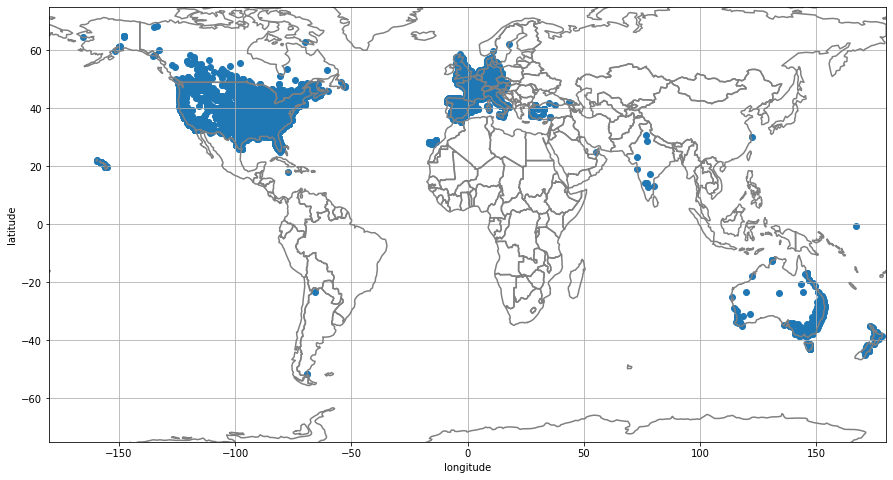

In [6]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

### 0.2 [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [7]:
def split_shards(file, folder='shard', capacity=20000):
    import pickle, os, math, gc
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity
    if nshards * capacity < len(dataset):
        nshards += 1

    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i + 1) * capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()


def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


# should return iterator, which goes through all elements, consequently opening files
# use ``yield`` operator to simplify your code
def iterate_dataset(items, folder="shard", capacity=20000):
    nshards = items // capacity
    if nshards * capacity < items:
        nshards += 1

    for i in range(nshards):
        with open(f"{folder}/{i}", "rb") as f:
            shard = pickle.load(f)
            for el in shard:
                yield el

In [8]:
split_shards("datasets/poi_sample01.pickle")

asserts:

In [9]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [10]:
import numpy as np

for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i, :], dataset_get([i])[0][0], atol=5 * 1e-2), ""

In [11]:
dataset_get([1, 10, 1000234, N - 1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

## And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

## 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

### 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius. Clarification: for simplicity **radius is given in units of coordinates (degrees)**, not kilometers or meters.

In [12]:
def build_geospacial_index(points, leaf_size=5) -> BallTree:  # or KDTree here
    return BallTree(points, leaf_size=leaf_size)


def kNN(query_point: list, k: int, index: BallTree) -> list:
    _, ind = index.query([query_point], k=k)
    return ind[0]


def inRadius(query_point: list, r: float, index: BallTree) -> list:
    ind = index.query_radius([query_point], r=r)
    return ind[0]

In [13]:
spaidx = build_geospacial_index(GEO)

In [14]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 351, 15497, 16642, 20423, 23285, 24681, 26327, 27121]
[13, 145, 351, 15497, 23285, 24681, 26327]


### 1.2 [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. make sure they never coinside by adding insignificant noise)

Pass the assert to get full points.

In [15]:
# Check the solution at 0.1.2 section
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 1000, spaidx)
    assert (p in r), "Query did not return itself"

### 1.3 [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.51s/it]


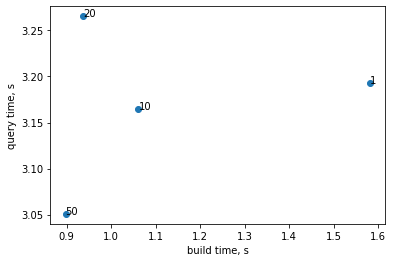

In [16]:
queries = random.sample(range(N), 1000)
leaf_sizes = [1, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)

    start = time.time()
    for q in queries:
        d, r = spaidx.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

### 1.4 [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

#### Solution: 
Find the diagonal of the rectangle. The point in the middle of the diagonal will be the point of the circumscribed circle around the given rectangle. The radius of this circle will be the diagonal of the rectangle divided by two. Find all points inside the given circle using `inRadius` function and filter them by `north-east` and `south-west` corners.

In [17]:
def get_in_range(ne, sw, spacial_index, GEO) -> list:
    center = (np.array(ne) + np.array(sw)) / 2
    radius = distance.euclidean(np.array(ne), np.array(sw)) / 2

    idx = inRadius(center, radius, spacial_index)
    points = GEO[idx]

    result = []
    for i in range(len(idx)):
        if (sw[0] <= points[i][0] <= ne[0]) and (sw[1] <= points[i][1] <= ne[1]):
            result.append(idx[i])

    return result

In [18]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [19]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
    lambda x: 'Manhattan, 80 Delancey St' in x[1],
    dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway


## 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

### 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts to get full points.

In [20]:
# this function returns a pair of tuples: NE and SW corners.
def get_town_range_coordinates(town: str, yandex_api_key: str) -> tuple:
    url = f"https://geocode-maps.yandex.ru/1.x/?apikey={yandex_api_key}&format=json&geocode={town}"

    response = requests.get(url)
    json = response.json()
    envelope = json["response"]["GeoObjectCollection"]["featureMember"][0]["GeoObject"]["boundedBy"]["Envelope"]

    lowerCorner = envelope["lowerCorner"]
    SW = tuple(map(float, lowerCorner.split()))

    upperCorner = envelope["upperCorner"]
    NE = tuple(map(float, upperCorner.split()))

    return NE, SW

If needed, request your key here: https://developers.google.com/maps/documentation/geocoding/get-api-key

Note, that from the **local machine** you may (!) need to have VPN enabled. For **colab** this should work smoothly.

asserts:

In [21]:
p = get_town_range_coordinates('Pittsburgh downtown', YA_API_KEY)
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1]

((-79.989227, 40.453579), (-80.022159, 40.428417))


### 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries! Pass the assert to get the points.

In [22]:
# should return dataset indices
def get_in_town(town, index, GEO, yandex_api_key) -> list:
    NE, SW = get_town_range_coordinates(town, yandex_api_key)
    return get_in_range(NE, SW, index, GEO)

In [23]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO, YA_API_KEY)

assert any(map(
    lambda x: 'US, Pittsburgh, 810 River Ave' in x[1],
    dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave


## 2.3. [5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [24]:
global GEO_CACHE
GEO_CACHE = {}


def get_town_range_coordinates_cached(town: str, yandex_api_key: str) -> tuple:
    global GEO_CACHE

    if town not in GEO_CACHE:  # cache miss
        NE, SW = get_town_range_coordinates(town, yandex_api_key)
        GEO_CACHE[town] = (NE, SW)

    return GEO_CACHE[town]


def get_in_town_cached(town: str, index, GEO, yandex_api_key: str) -> list:
    NE, SW = get_town_range_coordinates_cached(town, yandex_api_key)
    return get_in_range(NE, SW, index, GEO)

In [25]:
ids = get_in_town_cached('Boulder, CO', spaidx, GEO, YA_API_KEY)
print_starbucks(ids)

ids = get_in_town_cached('Boulder, CO', spaidx, GEO, YA_API_KEY)
print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [26]:
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download de_core_news_sm
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [27]:
#import sys
#!{sys.executable} -m spacy download en_core_web_md

In [28]:
nlp = spacy.load('en_core_web_md')
names = []

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait (and get **2 points**), but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices. Or maybe you want to use `fasttext` instead?

In [66]:
# if you need most frequent english words for some reason.
WORDS = set([a.strip() for a in open('datasets/words.txt', 'r').readlines()])

def embed(text, nlp):
    words = text.split()
    embeddings = [nlp.vocab[word].vector for word in words if word in nlp.vocab]
    mean = np.mean(embeddings, axis=0)
    norm = np.linalg.norm(mean)
    return mean / norm

In [67]:
embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

gc.collect()

  0%|                                                            | 60/2173512 [00:00<1:01:02, 593.41it/s]/var/folders/fd/yr1xd37x2jvf8qtn45mc898r0000gn/T/ipykernel_71843/154584411.py:9: RuntimeWarning: invalid value encountered in divide
  return mean / norm
100%|███████████████████████████████████████████████████████| 2173512/2173512 [01:37<00:00, 22278.56it/s]


0

## 3.2. [10 points] Vector index

Here you build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib (please refer to the corresponding lab). Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements to get full points:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should use cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index right on the disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [68]:
# This code was taken from https://github.com/spotify/annoy
embedding_index = AnnoyIndex(300, 'angular')
for idx, embedding in enumerate(tqdm(embeddings)):
    embedding_index.add_item(idx, embedding)
embedding_index.build(37) # trees
embedding_index.save('test.ann')

100%|███████████████████████████████████████████████████████| 2173512/2173512 [01:08<00:00, 31677.50it/s]


True

In [89]:
def get_vector_index():
    ei = AnnoyIndex(300, 'angular')
    ei.load('test.ann')
    return ei

def get_kNN_embeddings(embedding, k, index):
    return index.get_nns_by_vector(embedding, k)

In [90]:
embedding_index = get_vector_index()

In [91]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [92]:
def find(town, query) -> list:
    town_id = set(get_in_town(town, spaidx, GEO, YA_API_KEY))
    query_id = set(get_kNN_embeddings(embed(query, nlp), 15000, embedding_index))
    interested_id = town_id.intersection(query_id)
    return dataset_get(list(interested_id))

In [93]:
# 'Manhattan downtown' changed to 'Lower Manhattan', because this town interpreted differently in 
# Yandex maps compared to Google maps
items = find('Lower Manhattan', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])

[([-73.977375, 40.713703], 'Columbia University Development University, Education, University. US, New York, 475 Fdr Dr'), ([-73.987649, 40.721964], 'Ludlow Studio, Arts & Performance, Arts Center. US, New York, 177 Ludlow St Apt 2C')]


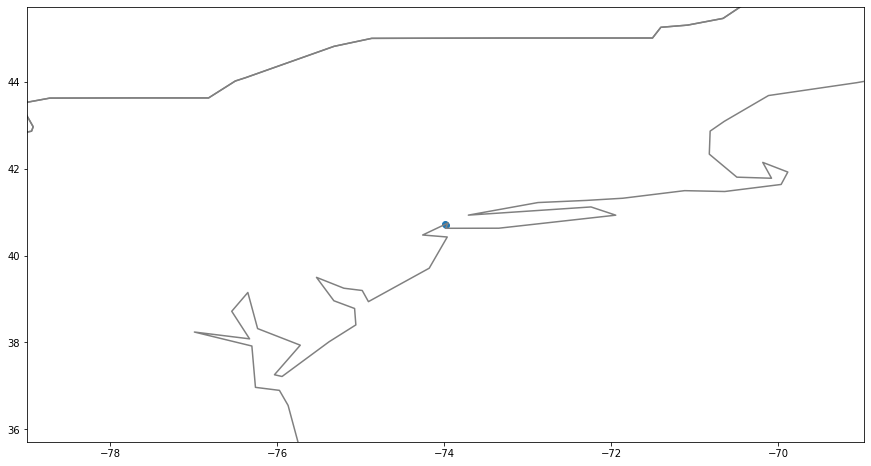

In [94]:
NE, SW = get_town_range_coordinates_cached('Lower Manhattan', YA_API_KEY)
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()